In [ ]:
!pip install scipy==1.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.6 MB 1.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


# import package

In [112]:
import time
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


# load data

In [3]:
path = '/content/drive/MyDrive/DM_HW3/hw3dataset/'
file_name = ['graph_1.txt', 'graph_2.txt', 'graph_3.txt', 'graph_4.txt', 'graph_5.txt', 'graph_6.txt', 'ibm-5000.txt']

In [4]:
data1 = pd.read_csv(path+file_name[0], sep=",", header=None)
data1.columns = ["v1", "v2"]
data2 = pd.read_csv(path+file_name[1], sep=",", header=None)
data2.columns = ["v1", "v2"]
data3 = pd.read_csv(path+file_name[2], sep=",", header=None)
data3.columns = ["v1", "v2"]
data4 = pd.read_csv(path+file_name[3], sep=",", header=None)
data4.columns = ["v1", "v2"]
data5 = pd.read_csv(path+file_name[4], sep=",", header=None)
data5.columns = ["v1", "v2"]
data6 = pd.read_csv(path+file_name[5], sep=",", header=None)
data6.columns = ["v1", "v2"]
data_ibm = pd.read_csv(path+file_name[6], delimiter='\s+', header=None)
data_ibm.columns = ["index","v1", "v2"]

In [18]:
G1 = nx.DiGraph()
for i in range(len(data1)):
  G1.add_edge(data1.iloc[i,0],data1.iloc[i,1])
G2 = nx.DiGraph()
for i in range(len(data2)):
  G2.add_edge(data2.iloc[i,0],data2.iloc[i,1])
G3 = nx.DiGraph()
for i in range(len(data3)):
  G3.add_edge(data3.iloc[i,0],data3.iloc[i,1])
G4 = nx.DiGraph()
for i in range(len(data4)):
  G4.add_edge(data4.iloc[i,0],data4.iloc[i,1])
G5 = nx.DiGraph()
for i in range(len(data5)):
  G5.add_edge(data5.iloc[i,0],data5.iloc[i,1])
G6 = nx.DiGraph()
for i in range(len(data6)):
  G6.add_edge(data6.iloc[i,0],data6.iloc[i,1])
Gibm = nx.DiGraph()
for i in range(len(data_ibm)):
  Gibm.add_edge(data_ibm.iloc[i,1],data_ibm.iloc[i,2])

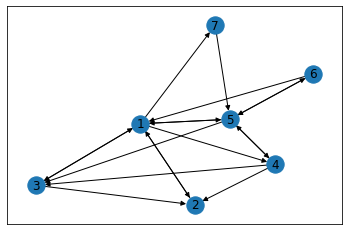

In [ ]:
nx.draw_networkx(G4)

# HITS

In [114]:
def HITS(G, k: int = 100):
  start = time.time()

  # 建立類別
  class node():
    def __init__(self):
      self.auth = []
      self.hub = []
    def set_initial(self, nodenumber):
      self.auth = np.ones(nodenumber+1)
      self.hub = np.ones(nodenumber+1)  

  # 初始化
  node = node()
  node.set_initial(max(G.nodes))

  # 迭代
  for i in range(1,k+1,1):
  ### 更新auth
    norm = 0
    for p in G.nodes:
      node.auth[p] = 0
      for q in G.predecessors(p):
        node.auth[p] += node.hub[q]
      norm += node.auth[p]**2
    norm = sqrt(norm)
    for p in range(len(G.nodes)):
      node.auth[p] = node.auth[p] / norm
  ### 更新hub
    norm = 0
    for p in G.nodes:
      node.hub[p] = 0
      for r in G.neighbors(p):
        node.hub[p] += node.auth[r]
      norm += node.hub[p]**2
    norm = sqrt(norm)
    for p in range(len(G.nodes)):
      node.hub[p] = node.hub[p] / norm
  
  end = time.time()
  print("執行時間：%f 秒" % (end - start))

  return node.auth[1:], node.hub[1:]

In [ ]:
auth, hub = HITS(G1, 10)
print("手刻hub  ：",hub)
print("手刻auth  ：",auth)

手刻hub  ： [0.33333333 0.33333333 0.33333333 0.33333333 0.74535599 0.        ]
手刻auth  ： [0.         0.33333333 0.33333333 0.33333333 0.33333333 0.74535599]


# PageRank

In [113]:
def pagerank(G, k: int = 100, d: float = 0.85):
  start = time.time()

  G_m = nx.to_numpy_matrix(G)
  M = np.squeeze(np.asarray(G_m))  

  N = M.shape[1]
  v = np.ones(N) / N
  M_hat = (d * M + (1 - d) / N)
  for i in range(k):
      v = M_hat @ v
  
  end = time.time()
  print("執行時間：%f 秒" % (end - start))

  return v

In [ ]:
v = pagerank(G1, 10, 0.85)
v

array([0.01932693, 0.01439156, 0.01022181, 0.00709797, 0.00436216,
       0.00200443])

# SimRank

In [115]:
### 計算
def calculate_SimRank(G, sim, u, v, d):
  if(u==v):
    return 1

  in_neighbors_u = list(i for i in G.predecessors(u))
  in_neighbors_v = list(i for i in G.predecessors(v))

  if(len(in_neighbors_u) == 0 or len(in_neighbors_v) == 0):
    return 0

  SimRank_sum = 0
  for w in in_neighbors_u:
    for x in in_neighbors_v:
      SimRank_sum += sim[w,x]

  scale = d / (len(in_neighbors_u) * len(in_neighbors_v))
  new_SimRank = scale * SimRank_sum

  return new_SimRank

### 迭代
def SimRank_one_iter(G, sim, d):
  new_SimRank = sim
  for u in G.nodes:
    for v in G.nodes:
      new_SimRank[u,v] = calculate_SimRank(G, sim, u, v, d)
  return new_SimRank

### 初始化 
def init_sim(G):
  sim = np.zeros((max(G.nodes)+1, max(G.nodes)+1))
  for i in range(len(sim)):
    sim[i,i] = 1
  return sim

### 執行
def get_simrank(G,d,k):
  start = time.time()

  old_sim = init_sim(G)
  new_sim = old_sim

  for i in range(k):
    old_sim = new_sim
    new_sim = SimRank_one_iter(G, new_sim, d)

  end = time.time()
  print("執行時間：%f 秒" % (end - start))

  return new_sim[1:,1:]

In [ ]:
#nx.simrank_similarity(G4,importance_factor=0.9)
s = get_simrank(G4,0.9,30)
s

array([[1.        , 0.56308238, 0.55339835, 0.55602116, 0.5440516 ,
        0.60279409, 0.50924824],
       [0.56308242, 1.        , 0.59679408, 0.56752252, 0.60393275,
        0.50221939, 0.63282566],
       [0.55339843, 0.59679414, 1.        , 0.62843652, 0.58456055,
        0.62685134, 0.63002169],
       [0.55602128, 0.56752264, 0.62843658, 1.        , 0.54545332,
        0.69482322, 0.69482314],
       [0.54405182, 0.60393289, 0.58456065, 0.5454534 , 1.        ,
        0.49059253, 0.60031427],
       [0.60279436, 0.50221976, 0.62685156, 0.69482332, 0.4905927 ,
        1.        , 0.48964664],
       [0.50924845, 0.63282585, 0.63002183, 0.69482322, 0.60031428,
        0.48964644, 1.        ]])

# 輸出檔案

In [116]:
auth, hub = HITS(G1, 30)
np.savetxt(path+"graph_1_HITS_authority.txt", auth, fmt='%f3')
np.savetxt(path+"graph_1_HITS_hub.txt", hub, fmt='%f3')

v = pagerank(G1, 30, 0.1)
np.savetxt(path+"graph_1_PageRank.txt", v, fmt='%f3')

s = get_simrank(G1,0.7,30)
np.savetxt(path+"graph_1_SimRank.txt", s, fmt='%f3')

執行時間：0.001585 秒
執行時間：0.000404 秒
執行時間：0.003021 秒


In [117]:
auth, hub = HITS(G2, 30)
np.savetxt(path+"graph_2_HITS_authority.txt", auth, fmt='%f3')
np.savetxt(path+"graph_2_HITS_hub.txt", hub, fmt='%f3')

v = pagerank(G2, 30, 0.1)
np.savetxt(path+"graph_2_PageRank.txt", v, fmt='%f3')

s = get_simrank(G2,0.7,30)
np.savetxt(path+"graph_2_SimRank.txt", s, fmt='%f3')

執行時間：0.001534 秒
執行時間：0.000283 秒
執行時間：0.001881 秒


In [118]:
auth, hub = HITS(G3, 30)
np.savetxt(path+"graph_3_HITS_authority.txt", auth, fmt='%f3')
np.savetxt(path+"graph_3_HITS_hub.txt", hub, fmt='%f3')

v = pagerank(G3, 30, 0.1)
np.savetxt(path+"graph_3_PageRank.txt", v, fmt='%f3')

s = get_simrank(G3,0.7,30)
np.savetxt(path+"graph_3_SimRank.txt", s, fmt='%f3')

執行時間：0.001008 秒
執行時間：0.000274 秒
執行時間：0.001438 秒


In [119]:
auth, hub = HITS(G4, 30)
np.savetxt(path+"graph_4_HITS_authority.txt", auth, fmt='%f3')
np.savetxt(path+"graph_4_HITS_hub.txt", hub, fmt='%f3')

v = pagerank(G4, 30, 0.1)
np.savetxt(path+"graph_4_PageRank.txt", v, fmt='%f3')

s = get_simrank(G4,0.7,30)
np.savetxt(path+"graph_4_SimRank.txt", s, fmt='%f3')

執行時間：0.001967 秒
執行時間：0.000418 秒
執行時間：0.006557 秒


In [120]:
auth, hub = HITS(G5, 30)
np.savetxt(path+"graph_5_HITS_authority.txt", auth, fmt='%f3')
np.savetxt(path+"graph_5_HITS_hub.txt", hub, fmt='%f3')

v = pagerank(G5, 30, 0.1)
np.savetxt(path+"graph_5_PageRank.txt", v, fmt='%f3')

s = get_simrank(G5,0.7,30)
np.savetxt(path+"graph_5_SimRank.txt", s, fmt='%f3')

執行時間：0.085670 秒
執行時間：0.009102 秒
執行時間：29.540547 秒


In [121]:
auth, hub = HITS(G6, 30)
np.savetxt(path+"graph_5_HITS_authority.txt", auth, fmt='%f3')
np.savetxt(path+"graph_5_HITS_hub.txt", hub, fmt='%f3')

v = pagerank(G6, 30, 0.1)
np.savetxt(path+"graph_5_PageRank.txt", v, fmt='%f3')

執行時間：0.285900 秒
執行時間：0.034997 秒


In [122]:
auth, hub = HITS(Gibm, 30)
np.savetxt(path+"ibm-5000_HITS_authority.tx", auth, fmt='%f3')
np.savetxt(path+"ibm-5000_HITS_hub.txt", hub, fmt='%f3')

v = pagerank(Gibm, 30, 0.1)
np.savetxt(path+"ibm-5000_PageRank.txt", v, fmt='%f3')

執行時間：0.231266 秒
執行時間：0.017145 秒


# Find a way

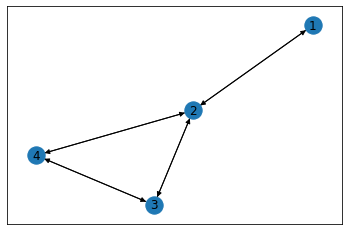

In [72]:
nx.draw_networkx(G3_a)

In [43]:
G1 = nx.DiGraph()
G1_a = nx.DiGraph()
for i in range(len(data1)):
  G1.add_edge(data1.iloc[i,0],data1.iloc[i,1])
  G1_a.add_edge(data1.iloc[i,0],data1.iloc[i,1])

auth, hub = HITS(G1, 30)
v = pagerank(G1, 30, 0.1)
G1_a.add_edge(1,3)
auth_a, hub_a = HITS(G1_a, 30)
v_a = pagerank(G1_a, 30, 0.1)

print("auth：",auth[1])
print("auth_a：",auth_a[1])
print("hub：",hub[1])
print("hub_a：",hub_a[1])
print("v：",v[1])
print("v_a：",v_a[1])

auth： 0.3333333333333333
auth_a： 0.5257311121190577
hub： 0.3333333333333333
hub_a： 0.5257311121190577
v： 0.1016376038415808
v_a： 0.15905858584641847


In [62]:
G2 = nx.DiGraph()
G2_a = nx.DiGraph()
for i in range(len(data2)):
  G2.add_edge(data2.iloc[i,0],data2.iloc[i,1])
  G2_a.add_edge(data2.iloc[i,0],data2.iloc[i,1])

auth, hub = HITS(G2, 30)
v = pagerank(G2, 30, 0.1)
G2_a.add_edge(1,3)
auth_a, hub_a = HITS(G2_a, 30)
v_a = pagerank(G2_a, 30, 0.1)

print("auth：",auth[1])
print("auth_a：",auth_a[1])
print("hub：",hub[1])
print("hub_a：",hub_a[1])
print("v：",v[1])
print("v_a：",v_a[1])

auth： 0.31034298554859197
auth_a： 0.5257311121190159
hub： 0.31034298554859197
hub_a： 0.5257311121190397
v： 0.19999999999999998
v_a： 0.3503252008608161


In [71]:
G3 = nx.DiGraph()
G3_a = nx.DiGraph()
for i in range(len(data3)):
  G3.add_edge(data3.iloc[i,0],data3.iloc[i,1])
  G3_a.add_edge(data3.iloc[i,0],data3.iloc[i,1])

auth, hub = HITS(G3, 30)
v = pagerank(G3, 30, 0.1)
G3_a.add_edge(2,4)
G3_a.add_edge(4,2)
auth_a, hub_a = HITS(G3_a, 30)
v_a = pagerank(G3_a, 30, 0.1)

print("auth：",auth[1])
print("auth_a：",auth_a[1])
print("hub：",hub[1])
print("hub_a：",hub_a[1])
print("v：",v[1])
print("v_a：",v_a[1])

auth： 0.5537647602692684
auth_a： 0.6560218873976725
hub： 0.5405353104935973
hub_a： 0.6560218873976725
v： 1.2025555525072718
v_a： 5.256995681404565


# damping factor 和 decay factor

<function matplotlib.pyplot.show(*args, **kw)>

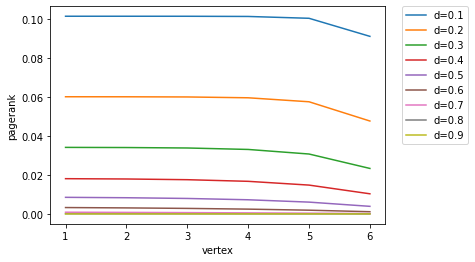

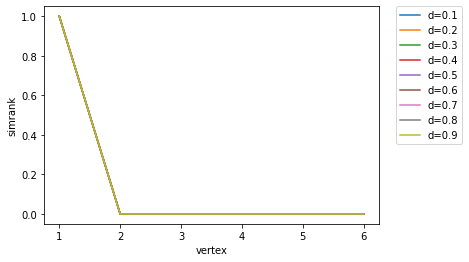

In [111]:
d = range(1,10,1)
d = [i/10 for i in d]
v_list = []
s_list = []
for i in d:
  v = pagerank(G1, 30, i)
  s = get_simrank(G1,i,30)
  v_list.append(v)
  s_list.append(s[0,:])

fig = plt.figure()
for i in range(len(d)):
  plt.plot(range(1,len(G1.nodes)+1),v_list[i],label='d='+str(d[i]))
plt.xlabel("vertex")
plt.ylabel("pagerank")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show

fig = plt.figure()
for i in range(len(d)):
  plt.plot(range(1,len(G1.nodes)+1),s_list[i],label='d='+str(d[i]))
plt.xlabel("vertex")
plt.ylabel("simrank")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

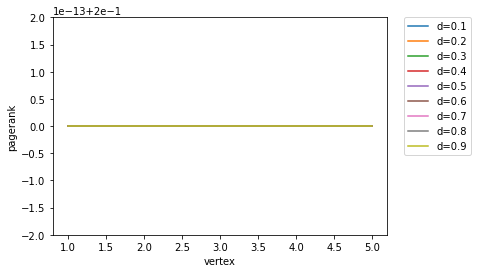

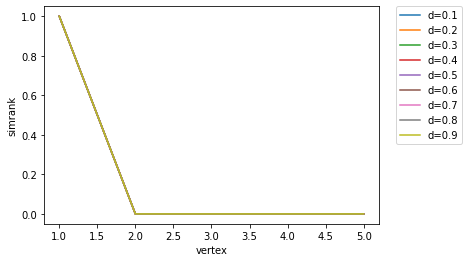

In [110]:
d = range(1,10,1)
d = [i/10 for i in d]
v_list = []
s_list = []
for i in d:
  v = pagerank(G2, 30, i)
  s = get_simrank(G2, i, 30)
  v_list.append(v)
  s_list.append(s[0,:])

fig = plt.figure()
for i in range(len(d)):
  plt.plot(range(1,len(G2.nodes)+1),v_list[i],label='d='+str(d[i]))
plt.xlabel("vertex")
plt.ylabel("pagerank")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show

fig = plt.figure()
for i in range(len(d)):
  plt.plot(range(1,len(G2.nodes)+1),s_list[i],label='d='+str(d[i]))
plt.xlabel("vertex")
plt.ylabel("simrank")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

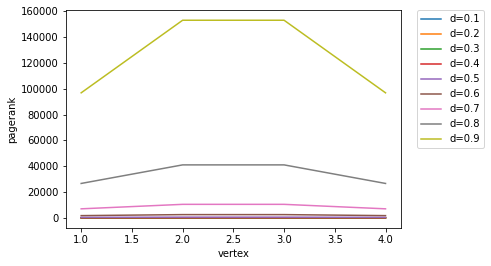

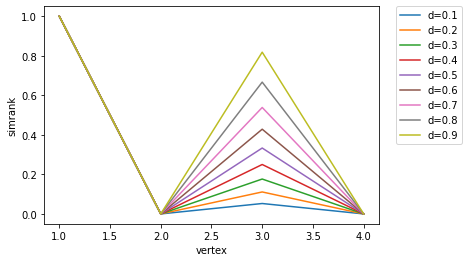

In [109]:
d = range(1,10,1)
d = [i/10 for i in d]
v_list = []
s_list = []
for i in d:
  v = pagerank(G3, 30, i)
  s = get_simrank(G3, i, 30)
  v_list.append(v)
  s_list.append(s[0,:])

fig = plt.figure()
for i in range(len(d)):
  plt.plot(range(1,len(G3.nodes)+1),v_list[i],label='d='+str(d[i]))
plt.xlabel("vertex")
plt.ylabel("pagerank")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show

fig = plt.figure()
for i in range(len(d)):
  plt.plot(range(1,len(G3.nodes)+1),s_list[i],label='d='+str(d[i]))
plt.xlabel("vertex")
plt.ylabel("simrank")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show

# 廢棄

In [ ]:
from itertools import product

def cal_simrank(G, u, v, c, k):
  if(k==0):
    return 1
  elif(u==v):
    return 1
  else:
    k = k-1
    in_neighbors_u = list(i for i in G.predecessors(u))
    in_neighbors_v = list(i for i in G.predecessors(v))
    if( (len(in_neighbors_u)*len(in_neighbors_v))==0 ):
      return 1
    else:
      scale = c / (len(in_neighbors_u) * len(in_neighbors_v))
      if(scale==0):
        return 0
      else:
        return scale * sum( cal_simrank(G, w, x, c, k) for w, x in product(in_neighbors_u,in_neighbors_v) )

def get_simrank(G, c, k):
  SimRank = np.ones((len(G.nodes)+1, len(G.nodes)+1))
  for u in G.nodes:
    for v in G.nodes:
        SimRank[u,v] = cal_simrank(G, u, v, c, k)
  return SimRank[1:,1:]

In [ ]:
print(data_ibm['v2'].max())
print(len(Gibm.nodes))
print(max(Gibm.nodes))

998
836
998
